In [10]:
import pickle
import random
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.manifold import TSNE

from src.parse_data import (
    TEXT_VIDEOCLIP_EMBED_MEAN, 
    VIDEO_EMBED_MEAN, 
    TEXT_CONVIRT_EMBED_MEAN,
    TEXT_MEDCLIP_EMBED_MEAN,
    MED_IMAGES_EMBED_MEAN,
    MED_IMAGES_MEDCLIP_EMBED_MEAN,
    TEXT_MEDCLIP_NO_AUG_EMBED_MEAN,
    MED_IMAGES_MEDCLIP_NO_AUG_EMBED_MEAN,
    TEXT_CLASP_EMBED_MEAN,
    AMINO_ACID_EMBED_MEAN,
    TEXT_TO_MED_GAP_PATH
)
from src.enums import Modality, DatasetType

In [13]:
def get_data_paths(dataset_type):
    gap_path = None
    if dataset_type == DatasetType.Video:
        data_path =  '/pasteur/u/esui/data/c3/data_videoclip_3k_train.pkl'
        # data_path = '/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/data_videoclip.pkl'
        text_mean_path = TEXT_VIDEOCLIP_EMBED_MEAN
        x_mean_path = VIDEO_EMBED_MEAN
    elif dataset_type == DatasetType.Medical:
        # data_path = '/pasteur/u/esui/data/c3/data_medclip_10k_train.pkl'
        data_path = '/pasteur/u/esui/data/c3/data_medclip_no_aug_10k_val.pkl'
        # data_path =  '/pasteur/u/esui/data/c3/data_convirt_10k_train.pkl'
        # data_path = '/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/data_convirt.pkl'
        # text_mean_path = TEXT_CONVIRT_EMBED_MEAN
        # text_mean_path = TEXT_MEDCLIP_EMBED_MEAN
        # x_mean_path = MED_IMAGES_MEDCLIP_EMBED_MEAN
        text_mean_path = TEXT_MEDCLIP_NO_AUG_EMBED_MEAN
        x_mean_path = MED_IMAGES_MEDCLIP_NO_AUG_EMBED_MEAN
        gap_path = TEXT_TO_MED_GAP_PATH
        # x_mean_path = MED_IMAGES_EMBED_MEAN
    elif dataset_type == DatasetType.Amino_Acid:
        data_path =  '/pasteur/u/esui/data/c3/data_clasp_train.pkl'
        # data_path = '/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/data_clasp.pkl'
        text_mean_path = TEXT_CLASP_EMBED_MEAN
        x_mean_path = AMINO_ACID_EMBED_MEAN
    else:
        raise NotImplementedError(f"dataset type {dataset_type} not implemented")
    
    print(data_path)
    print(text_mean_path)
    print(x_mean_path)
    return data_path, text_mean_path, x_mean_path, gap_path


def sample_embeds(modality, n, dataset_type):
    data_path, text_mean_path, x_mean_path, gap_path = get_data_paths(dataset_type)

    if modality == Modality.Vision:
        embed_mean_path = x_mean_path
        embed_key = "x_embed"
    else:
        embed_mean_path = text_mean_path
        embed_key = "y_embed"
    
    print("=> Loading mean")
    with open(embed_mean_path, 'rb') as f:
        embed_mean = pickle.load(f)
    
    with open(data_path, 'rb') as f:
        data = pickle.load(f)

    with open(gap_path, 'rb') as f:
        gap = pickle.load(f)
    
    indices = random.sample(list(data.keys()), n)
    
    embeds = [data[idx][embed_key].squeeze() for idx in indices]
    embeds = np.stack(embeds)
    embeds = embeds / np.linalg.norm(embeds, axis=1).reshape(-1, 1)
    
    return embeds, embed_mean, gap


def plot(dataset_type, n=100):
    embeds_language, embed_mean_language, gap = sample_embeds(Modality.Language, n, dataset_type)
    embeds_vision, embed_mean_vision, gap = sample_embeds(Modality.Vision, n, dataset_type)
    print(embed_mean_language.shape)
    print(embed_mean_vision.shape)
    
    tsne = TSNE()
    
    embeds = np.vstack([embeds_language, embeds_vision])
    embeds_removed_mean = np.vstack([embeds_language - embed_mean_language.numpy(),
                                    embeds_vision - embed_mean_vision.numpy()])
    embeds_removed_gap = np.vstack([embeds_language,
                                    embeds_vision - gap.numpy()])
    
    two_dimensional_embeds = tsne.fit_transform(embeds)
    
    plt.clf()
    plt.figure()
    plt.title(f"normed embeds")
    plt.scatter(two_dimensional_embeds[:n, 0], two_dimensional_embeds[:n, 1], color='red')
    plt.scatter(two_dimensional_embeds[n:, 0], two_dimensional_embeds[n:, 1], color='blue')
    plt.show()
    
    two_dimensional_embeds = tsne.fit_transform(embeds_removed_mean)
    
    plt.clf()
    plt.figure()
    plt.title(f"normed embeds removed mean")
    plt.scatter(two_dimensional_embeds[:n, 0], two_dimensional_embeds[:n, 1], color='red')
    plt.scatter(two_dimensional_embeds[n:, 0], two_dimensional_embeds[n:, 1], color='blue')
    plt.show()

    two_dimensional_embeds = tsne.fit_transform(embeds_removed_gap)

    plt.clf()
    plt.figure()
    plt.title(f"normed embeds removed gap")
    plt.scatter(two_dimensional_embeds[:n, 0], two_dimensional_embeds[:n, 1], color='red')
    plt.scatter(two_dimensional_embeds[n:, 0], two_dimensional_embeds[n:, 1], color='blue')
    plt.show()

    plt.clf()
    plt.figure()
    plt.title(f"normed embeds removed mean add noise")
    plt.scatter(two_dimensional_embeds[:n, 0], two_dimensional_embeds[:n, 1], color='red')
    plt.scatter(two_dimensional_embeds[n:, 0], two_dimensional_embeds[n:, 1], color='blue')
    plt.show()
    
def compute_residual(dataset_type, n=200):
    embeds_language, embed_mean_language, gap_ = sample_embeds(Modality.Language, n, dataset_type)
    embeds_vision, embed_mean_vision, gap_ = sample_embeds(Modality.Vision, n, dataset_type)
    
    gap = embeds_language - embeds_vision
    print(f"Norm of gap before subtracting means: {np.linalg.norm(gap)}")
    gap = (embeds_language - embed_mean_language.numpy()) - (embeds_vision - embed_mean_vision.numpy())
    print(f"Norm of gap after subtracting means: {np.linalg.norm(gap)}")
    gap = (embeds_language) - (embeds_vision - gap_.numpy())
    print(f"Norm of gap after subtracting gap: {np.linalg.norm(gap)}")

    # noise1 = np.random.randn(*embeds_language.shape) * 3
    # noise2 = np.random.randn(*embeds_language.shape) * 3
    # gap = (embeds_language + noise1 - embed_mean_language.numpy()) - (embeds_vision + noise2 - embed_mean_vision.numpy())
    # print(f"Norm of gap after adding noise and subtracting means: {np.linalg.norm(gap)}")


/pasteur/u/esui/data/c3/data_medclip_no_aug_10k_val.pkl
/pasteur/u/esui/data/c3/normalized_text_medclip_no_aug_10k_embed_mean.pkl
/pasteur/u/esui/data/c3/normalized_text_medclip_no_aug_med_image_10k_embed_mean.pkl
=> Loading mean
/pasteur/u/esui/data/c3/data_medclip_no_aug_10k_val.pkl
/pasteur/u/esui/data/c3/normalized_text_medclip_no_aug_10k_embed_mean.pkl
/pasteur/u/esui/data/c3/normalized_text_medclip_no_aug_med_image_10k_embed_mean.pkl
=> Loading mean
torch.Size([1, 512])
torch.Size([1, 512])


<Figure size 640x480 with 0 Axes>

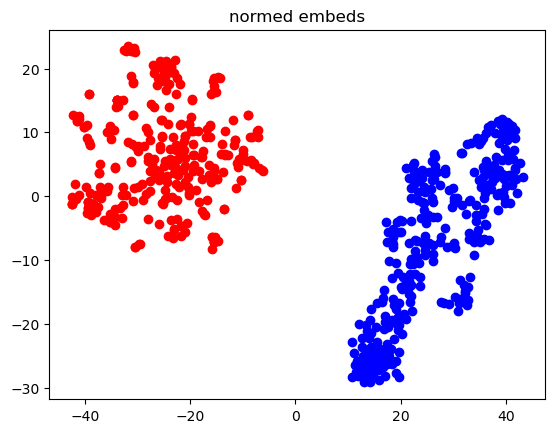

<Figure size 640x480 with 0 Axes>

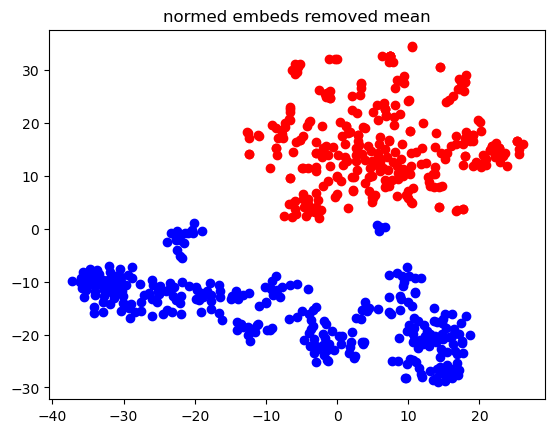

<Figure size 640x480 with 0 Axes>

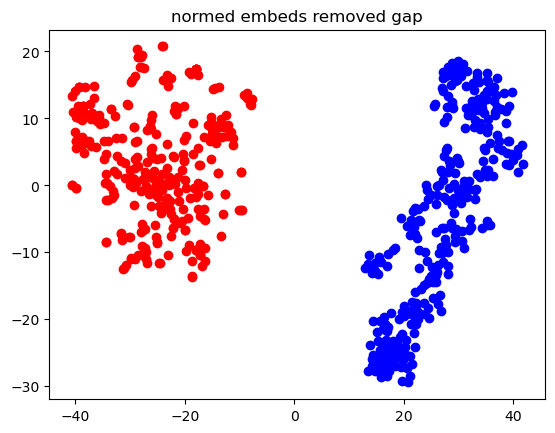

<Figure size 640x480 with 0 Axes>

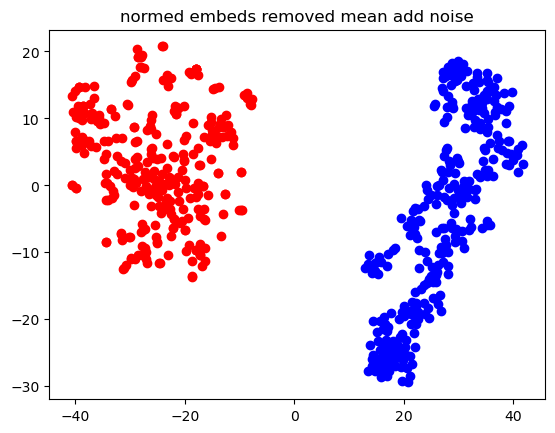

/pasteur/u/esui/data/c3/data_medclip_no_aug_10k_val.pkl
/pasteur/u/esui/data/c3/normalized_text_medclip_no_aug_10k_embed_mean.pkl
/pasteur/u/esui/data/c3/normalized_text_medclip_no_aug_med_image_10k_embed_mean.pkl
=> Loading mean


ValueError: too many values to unpack (expected 2)

In [12]:
plot(dataset_type='medical', n=300)
compute_residual(dataset_type='medical')

=> Loading mean
=> Loading mean


<Figure size 640x480 with 0 Axes>

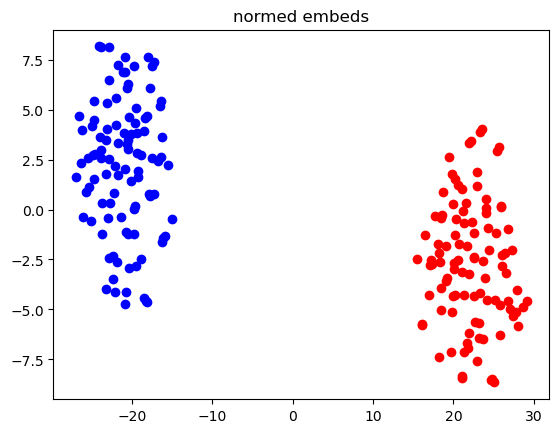

<Figure size 640x480 with 0 Axes>

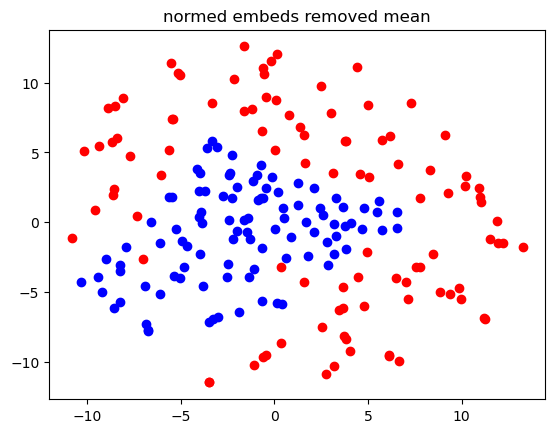

=> Loading mean
=> Loading mean
Norm of gap after subtracting means: 12.592034339904785


In [16]:
plot(dataset_type='video')
compute_residual(dataset_type='video')

/pasteur/u/esui/data/c3/data_clasp_train.pkl
/pasteur/u/esui/data/c3/normalized_text_clasp_embed_mean.pkl
/pasteur/u/esui/data/c3/normalized_text_amino_acid_embed_mean.pkl
=> Loading mean
/pasteur/u/esui/data/c3/data_clasp_train.pkl
/pasteur/u/esui/data/c3/normalized_text_clasp_embed_mean.pkl
/pasteur/u/esui/data/c3/normalized_text_amino_acid_embed_mean.pkl
=> Loading mean
torch.Size([1, 768])
torch.Size([1, 768])


<Figure size 640x480 with 0 Axes>

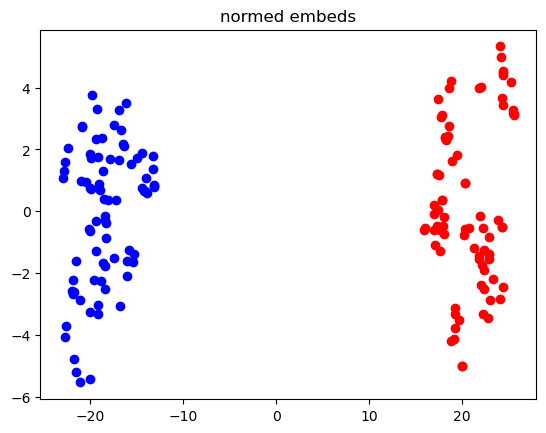

<Figure size 640x480 with 0 Axes>

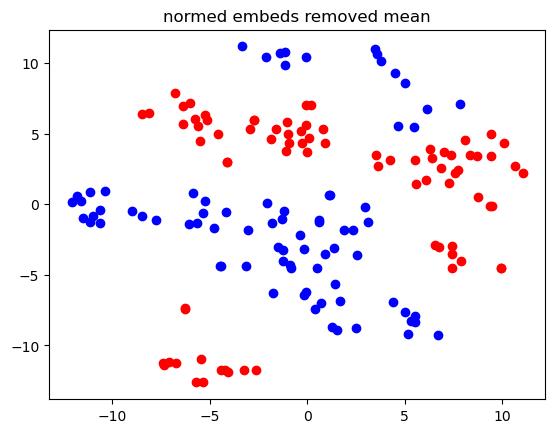

/pasteur/u/esui/data/c3/data_clasp_train.pkl
/pasteur/u/esui/data/c3/normalized_text_clasp_embed_mean.pkl
/pasteur/u/esui/data/c3/normalized_text_amino_acid_embed_mean.pkl
=> Loading mean
/pasteur/u/esui/data/c3/data_clasp_train.pkl
/pasteur/u/esui/data/c3/normalized_text_clasp_embed_mean.pkl
/pasteur/u/esui/data/c3/normalized_text_amino_acid_embed_mean.pkl
=> Loading mean
Norm of gap before subtracting means: 11.766586303710938
Norm of gap before subtracting means: 
Norm of gap after subtracting means: 7.197757244110107


In [9]:
plot(dataset_type='amino_acid', n=79)
compute_residual(dataset_type='amino_acid', n=79)

In [29]:
import json

dataset_type = 'amino_acid'
data_path, text_mean_path, x_mean_path = get_data_paths(dataset_type)
# data_path =  '/pasteur/u/esui/data/c3/data_convirt_10k_test.pkl'

# train_pred_path = '/pasteur/u/esui/data/video/output/video_stage1_unimodal_text_reconstruction_train_normed_mlp_seed_1234/2023_05_23_22_32_47/train_pred.json'
# test_pred_path = '/pasteur/u/esui/data/video/output/video_stage1_unimodal_text_reconstruction_train_normed_mlp_seed_1234/2023_05_24_10_15_44/test_pred.json'
# train_pred_path = '/pasteur/u/esui/data/video/output/video_stage1_unimodal_text_reconstruction_train_normed_mlp_seed_1234/2023_05_24_10_33_20/train_pred.json'
test_pred_path_c1 = '/pasteur/u/esui/data/medical/output/medical_img_stage1_unimodal_text_reconstruction_train_normed_mlp_seed_1234/2023_05_24_12_08_32/test_pred.json'
test_pred_path_c2_noise = '/pasteur/u/esui/data/medical/output/medical_img_stage1_unimodal_text_reconstruction_train_normed_mlp_add_gaussian_noise_level_0.126_seed_1234/2023_05_24_12_08_48/test_pred.json'
test_pred_path_c2_remove_mean = '/pasteur/u/esui/data/medical/output/medical_img_stage1_unimodal_text_reconstruction_train_normed_mlp_remove_mean_seed_1234/2023_05_24_12_08_48/test_pred.json'
test_pred_path_c3 = '/pasteur/u/esui/data/medical/output/medical_img_stage1_unimodal_text_reconstruction_train_normed_mlp_remove_mean_add_gaussian_noise_level_0.126_seed_1234/2023_05_24_12_20_41/test_pred.json'

with open(data_path, 'rb') as f:
    data = pickle.load(f)

for id in range(5):
    print(f"Ground truth: {data[id]['y']}")

# with open(test_pred_path_c1, 'rb') as f:
#     pred_c1 = json.load(f)

# with open(test_pred_path_c2_noise, 'rb') as f:
#     pred_c2_noise = json.load(f)

# with open(test_pred_path_c2_remove_mean, 'rb') as f:
#     pred_c2_remove_mean = json.load(f)

# with open(test_pred_path_c3, 'rb') as f:
#     pred_c3 = json.load(f)

# for i in range(5):

#     id = pred_c1[i]['image_id']
#     pred_cap_c1 = pred_c1[i]['caption']
#     pred_cap_c2_noise = pred_c2_noise[i]['caption']
#     pred_cap_c2_remove_mean = pred_c2_remove_mean[i]['caption']
#     pred_cap_c3 = pred_c3[i]['caption']

#     print(f"Ground truth: {data[id]['y']}")
#     print(f"Prediction C1: {pred_cap_c1}")
#     print(f"Prediction C2 add noise: {pred_cap_c2_noise}")
#     print(f"Prediction C2 remove mean: {pred_cap_c2_remove_mean}")
#     print(f"Prediction C3: {pred_cap_c3}")
#     print("="*80)

Ground truth: cardiomegaly is accompanied by pulmonary vascular congestion and worsening edema.
Prediction C1: the cardiac silhouette is enlarged, and there is a moderate - sized apical pleural effusion.
Prediction C2 add noise: the patient is status post thoracic bypass graft.
Prediction C2 remove mean: the patient is now moderately advanced in size with bilateral pleural effusions.
Prediction C3: the patient is status post median sternotomy.
Ground truth: minimal bilateral pleural effusions.
Prediction C1: pulmonary edema is present.
Prediction C2 add noise: there is a small left pleural effusion.
Prediction C2 remove mean: there is a left - sided pectoral pneumothorax.
Prediction C3: moderate pulmonary edema.
Ground truth: although no rib fractures are identified, this study has suboptimal sensitivity for detection of rib fractures.
Prediction C1: the heart is normal in size.
Prediction C2 add noise: pa and lateral views of the chest provided.
Prediction C2 remove mean: the cardiome

In [17]:
path = '/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/data_videoclip_3k.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)
    print(f"All data: {len(data)}")

splits = ['train', 'val', 'test']
data_paths = [f'/pasteur/u/esui/data/c3/data_videoclip_3k_{split}.pkl' for split in splits]

for i, split in enumerate(splits):
    print(split)
    with open(data_paths[i], 'rb') as f:
        data = pickle.load(f)
        print(len(data))
        if split == 'train':
            for j in range(3):
                print(data[j]['y'])

All data: 2990
train
2392
a handsome teen poses for the camera
a woman is adding eggs to pasta in a recipe
a man is building a remote-controlled robot
val
299
test
299


In [14]:
path = '/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/data_convirt_10k.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)
    print(f"All data: {len(data)}")

splits = ['train', 'val', 'test']
data_paths = [f'/pasteur/u/esui/data/c3/data_convirt_10k_{split}.pkl' for split in splits]

for i, split in enumerate(splits):
    print(split)
    with open(data_paths[i], 'rb') as f:
        data = pickle.load(f)
        print(len(data))

All data: 10000
train
8000
val
1000
test
1000
